# 📚 Hadith Semantic Search Project

Welcome to the Hadith Semantic Search project! This notebook demonstrates how to build an AI-powered search engine that understands the **meaning** of queries, not just keyword matches.

**What you'll learn:**
- How to process and clean Arabic text data
- Creating semantic embeddings for text understanding
- Building different search approaches (semantic, keyword, hybrid)
- Evaluating search system performance
- Deploying a searchable web interface

Let's get started! 🚀

---

## 📦 1. Library Imports

First, we'll import all necessary libraries for:
- **Data processing**: pandas, numpy
- **Visualization**: matplotlib, seaborn
- **NLP & Embeddings**: sentence-transformers, transformers
- **Search**: faiss, rank-bm25
- **Text processing**: re, collections

These libraries form the foundation of our semantic search system.

In [35]:
import re 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn  as sns
from collections import defaultdict

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
from tqdm import tqdm
import faiss
import statistics  
import pickle


---

## 📊 2. Data Loading & Cleaning

In this section, we'll:
1. Load the Hadith dataset from CSV
2. Explore the data structure and columns
3. Remove duplicate entries
4. Drop unnecessary columns
5. Analyze data quality

**Goal**: Prepare a clean dataset ready for embedding and search.


In [36]:
df = pd.read_csv("hadith.csv")
df

,_id,hadith_number,book_id,narrator_chain_ids,hadith_title,ayat_ids,xref_id,xref_url,islmwy_page,book_page,...,section,sub_sections,matn_text,isnad_text,h_wa_haddathana,url,main_subj,main_subj_ids,tree_subj_ids,tree_subj_list
0,bukhari-00001,1,islamweb-0000,['bukhari-00001-00'],قال سمعت رسول الله صلى الله عليه وسلم يقول,[],650001,https://www.islamweb.netnindex.php?page=hadith...,bukhari-00001,3,...,NaN,NaN,قال سمعت رسول الله صلى الله عليه وسلم يقول إنم...,1 حدثنا الحميدي عبد الله بن الزبير قال حدثنا س...,0,https://www.islamweb.net/ar/library/content/0/1/,إنما الأعمال بالنيات وإنما لكل امرئ ما نوى,3f160daad58b246c0fcf0f9787b5e544,"['1528c519f4e5ea76e89cf07cfe624744', '2d94aaec...","['نية الوضوء', 'النية في الغسل', 'النية في الت..."
1,bukhari-00002,2,islamweb-0000,['bukhari-00002-00'],أن,[],650002,https://www.islamweb.netnindex.php?page=hadith...,bukhari-00002,3,...,NaN,NaN,أن الحارث بن هشام رضي الله عنه سأل رسول الله ص...,2 حدثنا عبد الله بن يوسف قال أخبرنا مالك عن هش...,0,https://www.islamweb.net/ar/library/content/0/2/,أحيانا يأتيني مثل صلصلة الجرس وهو أشده علي فيف...,59775815873f7bcf1ad5af8739ba4e5a,"['cf8263dc232975240439e6b660dec8ed', 'a28e7161...","['سماع النبي أصوات الملائكة', 'ما يلاقيه النبي..."
2,bukhari-00004,4,islamweb-0000,['bukhari-00004-00'],أول ما بدئ به رسول الله صلى الله عليه وسلم من ...,['9a4940698dc3adb92b05d1b449589a1c'],650003,https://www.islamweb.netnindex.php?page=hadith...,bukhari-00003,4,...,NaN,NaN,أول ما بدئ به رسول الله صلى الله عليه وسلم من ...,4 حدثنا يحيى بن بكير قال حدثنا الليث عن عقيل ع...,0,https://www.islamweb.net/ar/library/content/0/3/,اقرأ قال ما أنا بقارئ قال فأخذني فغطني حتى بلغ...,a18885477030fbd0e51d68bac3b442a4,"['def658b952465a726192ace6e1295d43', '3d71f139...","['فضل التعلم', 'رؤيا النبي الصادقة', 'تحنث الن..."
3,bukhari-00005,5,islamweb-0000,['bukhari-00005-00'],في قوله تعالى,"['52d2bc30e7f2aea3fd86981e29064748', '76a16afe...",650004,https://www.islamweb.netnindex.php?page=hadith...,bukhari-00004,6,...,NaN,NaN,في قوله تعالى لا تحرك به لسانك لتعجل به قال كا...,5 حدثنا موسى بن إسماعيل قال حدثنا أبو عوانة قا...,0,https://www.islamweb.net/ar/library/content/0/4/,يعالج من التنزيل شدة وكان مما يحرك شفتيه فقال ...,56c2d89a04bc5114bda8b55df4707276,"['a28e7161f1888384e1f03a9d1982e108', '387ff557...","['ما يلاقيه النبي من شدة الوحي', 'من آداب التل..."
4,bukhari-00006,6,islamweb-0000,['bukhari-00006-00'],كان رسول الله صلى الله عليه وسلم,[],650005,https://www.islamweb.netnindex.php?page=hadith...,bukhari-00005,7,...,NaN,NaN,كان رسول الله صلى الله عليه وسلم أجود الناس وك...,6 حدثنا عبدان قال أخبرنا عبد الله قال أخبرنا ي...,1,https://www.islamweb.net/ar/library/content/0/5/,أجود الناس وكان أجود ما يكون في رمضان حين يلقا...,c07b17af68c3043bfa8d6134402102ad,"['e4fe3ace7c48a7954ff46f8f96d219e0', 'dd400ab2...","['تعاهد القرآن الكريم', 'معارضة جبريل والنبي ب..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6452,bukhari-07120,7120,islamweb-0000,['bukhari-07120-00'],قال سمعت النبي صلى الله عليه وسلم يقول قال الل...,[],657004,https://www.islamweb.netnindex.php?page=hadith...,bukhari-07232,2748,...,NaN,NaN,قال سمعت النبي صلى الله عليه وسلم يقول قال الل...,7120 حدثنا محمد بن العلاء حدثنا ابن فضيل عن عم...,0,https://www.islamweb.net/ar/library/content/0/...,ومن أظلم [ ص: 2748 ] ممن ذهب يخلق كخلقي فليخلق...,39316a572dac5bff7d3ae9d455551fc3,"['0300a9bbfbf582116f0babe3ab09529e', '5039d4c8...","['حكم الصور', 'أنواع الكبائر']"
6453,bukhari-07121,7121,islamweb-0000,['bukhari-07121-00'],عن النبي صلى الله عليه وسلم قال,[],657005,https://www.islamweb.netnindex.php?page=hadith...,bukhari-07233,2748,...,NaN,NaN,عن النبي صلى الله عليه وسلم قال مثل المؤمن الذ...,7121 حدثنا هدبة بن خالد حدثنا همام حدثنا قتادة...,0,https://www.islamweb.net/ar/library/content/0/...,مثل المؤمن الذي يقرأ القرآن كالأترجة طعمها طيب...,4347aeb30c9d92ba092e8fe48bd6102a,"['5b4973db5874cdb6cf1cf92d246bdd28', '2ba370ea...","['فضل تلاوة القرآن الكريم', 'فضل من قرأ القرآن..."
6454,bukhari-07122,7122,islamwe

---

## 📈 3. Data Visualization & Analysis

Let's visualize our data to understand:
- Distribution of Hadith text lengths
- Presence of outliers
- Statistical properties of the dataset

This helps us understand what we're working with and identify any potential issues.

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6457 entries, 0 to 6456
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   _id                 6457 non-null   object 
 1   hadith_number       6457 non-null   int64  
 2   book_id             6457 non-null   object 
 3   narrator_chain_ids  6457 non-null   object 
 4   hadith_title        6083 non-null   object 
 5   ayat_ids            6457 non-null   object 
 6   xref_id             6457 non-null   int64  
 7   xref_url            6088 non-null   object 
 8   islmwy_page         6457 non-null   object 
 9   book_page           6457 non-null   int64  
 10  hadith_status       6457 non-null   object 
 11  book_name           6415 non-null   object 
 12  page_title          6457 non-null   object 
 13  chapter             6457 non-null   object 
 14  chapter_id          6457 non-null   object 
 15  section             511 non-null    object 
 16  sub_se

In [38]:
df =df.drop(columns=["main_subj_ids","tree_subj_ids","tree_subj_list","h_wa_haddathana","sub_sections",
    "chapter_id","chapter","page_title","book_name","book_page","islmwy_page","xref_id","narrator_chain_ids","book_id","hadith_number","_id","section"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6457 entries, 0 to 6456
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   hadith_title   6083 non-null   object
 1   ayat_ids       6457 non-null   object
 2   xref_url       6088 non-null   object
 3   hadith_status  6457 non-null   object
 4   matn_text      6457 non-null   object
 5   isnad_text     6457 non-null   object
 6   url            6457 non-null   object
 7   main_subj      6457 non-null   object
dtypes: object(8)
memory usage: 403.7+ KB


In [39]:
df["main_subj"].duplicated().value_counts()

main_subj
False    5976
True      481
Name: count, dtype: int64

In [40]:
print(df["matn_text"].duplicated().sum())
# Now try dropping again
df = df.drop_duplicates(subset=['matn_text'])
print(df["matn_text"].duplicated().sum())


84
0


In [41]:
(df["main_subj"].value_counts()).count()

np.int64(5950)

In [42]:
df.duplicated().value_counts()

False    6373
Name: count, dtype: int64

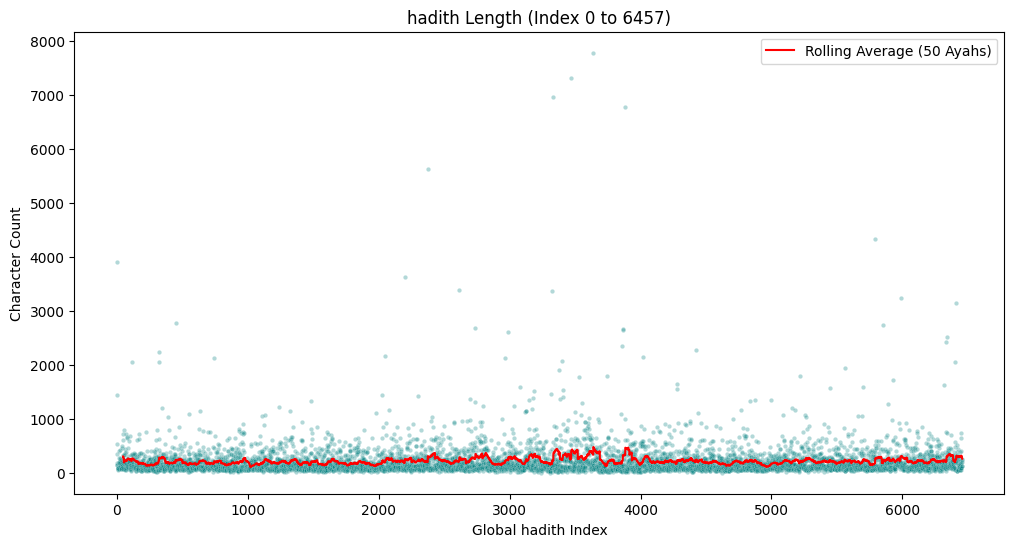

In [43]:
# Calculate length first
df['matn_len'] = df['matn_text'].str.len()

plt.figure(figsize=(12, 6))
# s=1 makes the points small so they don't overlap too much
sns.scatterplot(data=df, x=df.index, y='matn_len', alpha=0.3, s=10, color="teal")

# Add a rolling average to see the trend (the 'shape' of the lengths)
df['matn_len'].rolling(window=50).mean().plot(color='red', label='Rolling Average (50 Ayahs)')

plt.title("hadith Length (Index 0 to 6457)")
plt.xlabel("Global hadith Index")
plt.ylabel("Character Count")
plt.legend()
plt.show()

<Axes: xlabel='matn_len'>

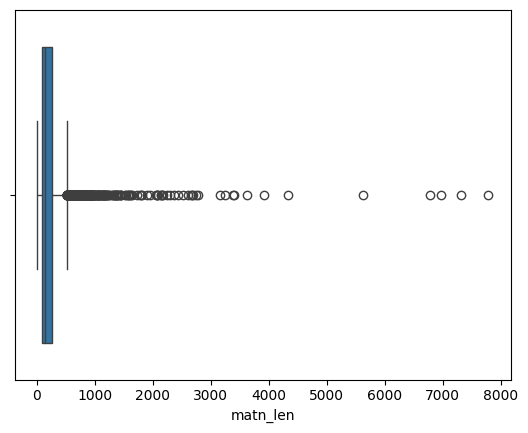

In [44]:
sns.boxplot(data=df, x='matn_len')

In [45]:
df["matn_len"].sort_values(ascending=False)

3640    7787
3471    7322
3335    6966
3884    6782
2376    5633
        ... 
3997      16
3362      15
4622      14
3237      13
3312      10
Name: matn_len, Length: 6373, dtype: int64

---

## 🔤 4. Text Preprocessing

Arabic text requires special preprocessing:
- **Remove tashkeel** 
- Normalize characters
- Clean special symbols

This normalization improves matching and reduces vocabulary size while preserving meaning.

In [46]:
def remove_tashkeel(text):
    tashkeel_pattern = re.compile(
        r'[\u0617-\u061A\u064B-\u0652]'
    )
    return re.sub(tashkeel_pattern, '', text)

def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def preprocess_arabic(text):
    text = remove_tashkeel(text)
    text = normalize_arabic(text)
    return text

df["clean_text"] = df["matn_text"].astype(str).apply(preprocess_arabic)


---

## 🤖 5. Model Loading & Embedding Generation

We'll use the **paraphrase-multilingual-MiniLM-L12-v2** model:
- Supports Arabic and 50+ languages
- Creates 384-dimensional embeddings
- Captures semantic meaning in vector space
- Normalized embeddings for cosine similarity

**Process**: Each Hadith → 384-dimensional vector representing its meaning

In [47]:

# load tokenizer + model
tokenizer = AutoTokenizer.from_pretrained(
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
)
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")
model.max_seq_length = 512  # global safety

# parameters
START_CHUNK_TOKENS = 350     # starting chunk size (safe)
MIN_CHUNK_TOKENS = 50        # fallback minimum
REDUCE_STEP = 50             # reduce chunk size by this step if too long
MODEL_MAX_TOKENS = model.max_seq_length  # should be 512

def chunk_text_safe(text, tokenizer, start_chunk_tokens=START_CHUNK_TOKENS,
                    reduce_step=REDUCE_STEP, min_chunk_tokens=MIN_CHUNK_TOKENS,
                    model_max_tokens=MODEL_MAX_TOKENS):
    """
    Return a list of decoded text chunks such that when each chunk is tokenized
    with add_special_tokens=True its length <= model_max_tokens.
    """
    if not isinstance(text, str) or len(text.strip()) == 0:
        return []

    enc = tokenizer(text, add_special_tokens=False, return_attention_mask=False)
    tokens = enc["input_ids"]
    n = len(tokens)
    chunks = []
    i = 0

    while i < n:
        # start with the start_chunk_tokens or the remaining tokens
        size = min(start_chunk_tokens, n - i)

        # reduce size until the re-tokenized chunk fits
        while size >= min_chunk_tokens:
            chunk_tokens = tokens[i:i + size]
            chunk_text = tokenizer.decode(chunk_tokens, skip_special_tokens=True)

            # re-tokenize with special tokens to simulate what model will do
            re_enc = tokenizer(chunk_text, add_special_tokens=True, return_attention_mask=False)
            if len(re_enc["input_ids"]) <= model_max_tokens:
                chunks.append(chunk_text)
                i += size
                break
            else:
                size -= reduce_step

        # if we exit while with too small size, force-slice to model_max_tokens-2
        if size < min_chunk_tokens:
            forced_size = min(model_max_tokens - 2, n - i)  # leave room for special tokens
            if forced_size <= 0:
                # defensive fallback: decode single token (shouldn't happen often)
                chunk_text = tokenizer.decode(tokens[i:i+1], skip_special_tokens=True)
                chunks.append(chunk_text)
                i += 1
            else:
                chunk_tokens = tokens[i:i + forced_size]
                chunk_text = tokenizer.decode(chunk_tokens, skip_special_tokens=True)
                # final check (very unlikely to exceed now)
                re_enc = tokenizer(chunk_text, add_special_tokens=True, return_attention_mask=False)
                # if still too long, further split by characters (last resort)
                if len(re_enc["input_ids"]) <= model_max_tokens:
                    chunks.append(chunk_text)
                    i += forced_size
                else:
                    # last resort: split decoded text into halves (char split)
                    half = len(chunk_text) // 2
                    left = chunk_text[:half].strip()
                    right = chunk_text[half:].strip()
                    if left:
                        chunks.append(left)
                    if right:
                        chunks.append(right)
                    i += forced_size

    return chunks

def embed_hadith_safe(text, tokenizer, model,
                      start_chunk_tokens=START_CHUNK_TOKENS):
    """
    Tokenize-safe chunking + embedding + mean pooling (returns 1 vector per hadith).
    """
    chunks = chunk_text_safe(text, tokenizer, start_chunk_tokens=start_chunk_tokens)
    if len(chunks) == 0:
        # empty embedding (handle consistently)
        dim = model.get_sentence_embedding_dimension()
        return np.zeros(dim, dtype=np.float32)

    # encode chunk list (SentenceTransformer will handle internal preprocessing)
    chunk_embeddings = model.encode(chunks, normalize_embeddings=True)

    # mean pooling (axis 0)
    hadith_emb = np.mean(chunk_embeddings, axis=0)

    # normalize final vector
    norm = np.linalg.norm(hadith_emb)
    if norm > 0:
        hadith_emb = hadith_emb / norm

    return hadith_emb

# Build all hadith embeddings with progress bar and diagnostics
hadith_embeddings = []
chunk_counts = []
for text in tqdm(df["clean_text"].astype(str).tolist(), desc="Embedding hadiths"):
    emb = embed_hadith_safe(text, tokenizer, model)
    hadith_embeddings.append(emb)
    chunk_counts.append(len(chunk_text_safe(text, tokenizer)))

hadith_embeddings = np.vstack(hadith_embeddings)  # shape = (n_hadith, dim)

# Quick diagnostics

print("Embedding shape:", hadith_embeddings.shape)
print("Chunks per hadith: min,median,mean,max =", (min(chunk_counts), statistics.median(chunk_counts),
                                                   statistics.mean(chunk_counts), max(chunk_counts)))


Embedding hadiths: 100%|██████████| 6373/6373 [01:39<00:00, 63.89it/s]

Embedding shape: (6373, 768)
Chunks per hadith: min,median,mean,max = (1, 1, 1.0214969402165386, 8)


---

## 🎯 6. Evaluation Setup

To measure our search system's performance, we need:
1. **Test queries** with known relevant Hadiths
2. **Evaluation metrics**: Precision@K and Recall@K
3. **Baseline for comparison**

We'll create 5 diverse queries covering different topics:
- Intention (niyyah)
- Prayer virtues
- Neighbor rights
- Seeking knowledge
- Charity

Each query has manually identified relevant Hadith IDs for evaluation.

In [48]:
evaluation_queries = {
    "q1":  {"query": "أهمية النية وأثرها في قبول الأعمال", "relevant_ids": [0,1056,5663,5900,5438]},
    "q2":  {"query": "فضل الصدق في القول والعمل وأثره على حياة المؤمن", "relevant_ids": [5191,447,2178,5106,1286]},
    "q3":  {"query": "حقوق الوالدين ووجوب برهما والإحسان إليهما", "relevant_ids": [5650,2368,5825,4997,6429]},
    "q4":  {"query": "أفضل الأعمال وشروط قبول العمل عند الله", "relevant_ids": [4990,4891,1775,1286,4692]},
    "q5":  {"query": "صفات المؤمنين وأثر الإيمان في السلوك", "relevant_ids": [7,46,2481,6224,2917]},
    "q6":  {"query": "الصبر على البلاء واحتساب الأجر", "relevant_ids": [1189,1174,6002,6338,5582]},
    "q7":  {"query": "الإحسان إلى الجار وصلة الرحم", "relevant_ids": [5924,5927,5923,2015,5036]},
    "q8": {"query": "الفرق بين المال الحلال والحرام", "relevant_ids": [1872,3870,1283,2253,6105]},
    "q9": {"query": "خطر الحسد وطرق الوقاية منه", "relevant_ids": [6424,6067,5031,1285,69]},
    "q10": {"query": "فضل الصدقة وأثرها في تطهير المال", "relevant_ids": [4418,1301,1280,2067]},
    "q11": {"query": "تحريم الكذب وفضل الصدق", "relevant_ids": [5106,3845,2393,4379,1180]},
    "q12": {"query": "فضل نشر العلم وتعليمه", "relevant_ids": [94,6001,4315,79,75]},
    "q13": {"query": "فضل الصلاة في وقتها وأثرها على المسلم", "relevant_ids": [53,732,626,6429,460]},
    "q14": {"query": "رعاية اليتيم وفضل الإحسان إليه", "relevant_ids": [1857,2017,5003,4376,5023]},
    "q15": {"query": "فضل التواضع والتحذير من الكبر", "relevant_ids": [6421,5325,603,2313,65]},
    "q16": {"query": "الرفق والرحمة في معاملة الناس", "relevant_ids": [6282,5031,3242,2416,6350]},
    "q17": {"query": " الاستغفار والتوبة ", "relevant_ids": [2974,1212,1050,6350,149]},
    "q18": {"query": "التوكل على الله مع الأخذ بالأسباب", "relevant_ids": [4692,73,46,22,2414]},
    "q19": {"query": "حقوق العمال والخدم والعدل في معاملتهم", "relevant_ids": [417,2249,2223,2027,2026]},
    "q20": {"query": " مساعدة الفقراء والإحسان إليهم", "relevant_ids": [2471,1347,2139,2702,5025]},
}

In [49]:
def precision_at_k(retrieved_ids, relevant_ids, k):
    retrieved_k = set(retrieved_ids[:k])
    relevant = set(relevant_ids)
    return len(retrieved_k & relevant) / k


def recall_at_k(retrieved_ids, relevant_ids, k):
    retrieved_k = set(retrieved_ids[:k])
    relevant = set(relevant_ids)
    if len(relevant) == 0:
        return 0.0
    return len(retrieved_k & relevant) / len(relevant)

---

## 🔍 7. FAISS-based Semantic Search

**FAISS** (Facebook AI Similarity Search) enables fast similarity search:

**How it works:**
1. Build FAISS index from all Hadith embeddings
2. Encode query into same embedding space
3. Find K nearest neighbors using cosine similarity
4. Return most semantically similar Hadiths

**Advantages:**
- ✅ Understands meaning beyond keywords
- ✅ Fast retrieval even with thousands of Hadiths
- ✅ Works with different phrasings of same concept

**Limitations:**
- ❌ May miss exact keyword matches
- ❌ Purely semantic (no keyword signals)

In [50]:
dim = hadith_embeddings.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(hadith_embeddings)


In [51]:
q = model.encode(
    "ما هو الحديث الذي يشرح أهمية النية وأثرها في قبول الأعمال عند الله",normalize_embeddings=True)
scores, indices = index.search(q.reshape(1, -1), k=5)
print(scores)
print("-"*50)
print(indices)

[[0.7596841  0.75739163 0.7504262  0.7448545  0.74430674]]
--------------------------------------------------
[[4040 5135 1269 2105 1279]]


In [52]:

results = []
for idx in indices[0]:
    results.append({
        "ayat_ids": df.loc[idx,"ayat_ids"],
        "xref_url": df.loc[idx,"xref_url"],
        "url": df.loc[idx,"url"],
        "isnad_text": df.loc[idx,"isnad_text"],
        "hadith_status": df.loc[idx,"hadith_status"],
        "matn": df.loc[idx,"matn_text"]})
pd.DataFrame(results)#.loc[0,"tafsir"]

,ayat_ids,xref_url,url,isnad_text,hadith_status,matn
0,[],NaN,https://www.islamweb.net/ar/library/content/0/...,4648 حدثنا محمد بن كثير أخبرنا سفيان حدثنا عبد...,Sahih,كنا نرفع الخشب بقصر ثلاثة أذرع أو أقل فنرفعه ل...
1,[],https://www.islamweb.netnindex.php?page=hadith...,https://www.islamweb.net/ar/library/content/0/...,5773 حدثني إسحاق حدثنا النضر أخبرنا شعبة عن سع...,Sahih,لما بعثه رسول الله صلى الله عليه وسلم ومعاذ بن...
2,[],https://www.islamweb.netnindex.php?page=hadith...,https://www.islamweb.net/ar/library/content/0/...,1324 حدثنا موسى بن إسماعيل حدثنا أبو عوانة عن ...,Sahih,قال رسول الله صلى الله عليه وسلم في مرضه الذي ...
3,[],https://www.islamweb.netnindex.php?page=hadith...,https://www.islamweb.net/ar/library/content/0/...,2237 حدثنا قتيبة حدثنا عبد العزيز عن أبي حازم ...,Sahih,أتي رسول الله صلى الله عليه وسلم بقدح فشرب وعن...
4,[],https://www.islamweb.netnindex.php?page=hadith...,https://www.islamweb.net/ar/library/content/0/...,1336 حدثنا ابن نمير قال حدثني أبي حدثنا إسماعي...,Sahih,بايعت النبي صلى الله عليه وسلم على إقام الصلاة...


In [53]:
pd.DataFrame(results).loc[4,"matn"]

'بايعت النبي صلى الله عليه وسلم على إقام الصلاة وإيتاء الزكاة والنصح لكل مسلم'

In [54]:
total_p ,total_r = 0,0
for q ,b in evaluation_queries.items():
    q = model.encode(
        b["query"],normalize_embeddings=True)
    _, indices = index.search(q.reshape(1, -1), k=5)
    total_p+=precision_at_k(indices[0], b["relevant_ids"], 5)
    total_r+=recall_at_k(indices[0], b["relevant_ids"], 5)

print(total_p/len(evaluation_queries))
print(total_r/len(evaluation_queries))

0.030000000000000006
0.030000000000000006


---

## 🔄 8. Hybrid Search: BM25 + Semantic Reranking

Combining the best of both worlds!

**BM25** (Best Match 25):
- Classic information retrieval algorithm
- Ranks documents by keyword relevance
- Fast and interpretable

**Hybrid Approach:**
1. **Stage 1 (BM25)**: Retrieve top-50 candidates using keyword matching
2. **Stage 2 (Semantic)**: Re-rank candidates using semantic similarity
3. **Stage 3 (Fusion)**: Combine scores with weighted average

**Formula:**

In [55]:
def bm25_tokenize(text):
    return text.split()


In [56]:
from rank_bm25 import BM25Okapi
df["hadith_embeddings"] = list(hadith_embeddings)
corpus = df["clean_text"].tolist()
tokenized_corpus = [bm25_tokenize(text) for text in corpus]
bm25 = BM25Okapi(tokenized_corpus)
def preprocess_query(query):
    query = preprocess_arabic(query)
    return bm25_tokenize(query)
def bm25_retrieve(query, bm25, top_k=50):
    tokenized_query = preprocess_query(query)
    scores = bm25.get_scores(tokenized_query)
    top_indices = np.argsort(scores)[::-1][:top_k]
    return top_indices, scores[top_indices]

In [57]:
def semantic_rerank(query, candidate_indices, candidate_bm25_scores, model, embeddings, alpha=0.8):
    query_emb = model.encode(query, normalize_embeddings=True)

    candidate_embs = embeddings[candidate_indices]
    semantic_scores = candidate_embs @ query_emb  # cosine similarity

    # Normalize BM25 scores
    bm25_norm = candidate_bm25_scores / (candidate_bm25_scores.max() + 1e-8)

    final_scores = alpha * semantic_scores + (1 - alpha) * bm25_norm

    return final_scores


In [58]:
def hybrid_search(query, df, bm25, model, embeddings, top_k=5):
    candidate_indices, bm25_scores = bm25_retrieve(query, bm25, top_k=50)

    final_scores = semantic_rerank(
        query,
        candidate_indices,
        bm25_scores,
        model,
        embeddings,
        alpha=0.8
    )

    ranked_idx = np.argsort(final_scores)[::-1][:top_k]
    final_indices = candidate_indices[ranked_idx]

    return df.iloc[final_indices].copy()#.reset_index(drop=True)

x= hybrid_search(query="ما هو الحديث الذي يشرح أهمية النية وأثرها في قبول الأعمال عند الله", df=df, bm25=bm25, model=model, embeddings = hadith_embeddings,top_k=5)
x

,hadith_title,ayat_ids,xref_url,hadith_status,matn_text,isnad_text,url,main_subj,matn_len,clean_text,hadith_embeddings
5457,سئل النبي صلى الله عليه وسلم أي الأعمال أحب إل...,[],https://www.islamweb.netnindex.php?page=hadith...,Sahih,سئل النبي صلى الله عليه وسلم أي الأعمال أحب إل...,6100 حدثني محمد بن عرعرة حدثنا شعبة عن سعد بن ...,https://www.islamweb.net/ar/library/content/0/...,أدومها وإن قل وقال اكلفوا من الأعمال ما تطيقون,103,سيل النبي صلي الله عليه وسلم اي الاعمال احب ال...,"[0.0041250363, 0.046735667, -0.009573723, -0.0..."
4071,NaN,[],NaN,Sahih,في الكوثر هو الخير الذي أعطاه الله إياه,4682 حدثنا يعقوب بن إبراهيم حدثنا هشيم حدثنا أ...,https://www.islamweb.net/ar/library/content/0/...,في الكوثر هو الخير الذي أعطاه الله إياه,39,في الكوثر هو الخير الذي اعطاه الله اياه,"[0.010366638, 0.053912513, -0.010627878, 0.042..."
0,قال سمعت رسول الله صلى الله عليه وسلم يقول,[],https://www.islamweb.netnindex.php?page=hadith...,Sahih,قال سمعت رسول الله صلى الله عليه وسلم يقول إنم...,1 حدثنا الحميدي عبد الله بن الزبير قال حدثنا س...,https://www.islamweb.net/ar/library/content/0/1/,إنما الأعمال بالنيات وإنما لكل امرئ ما نوى,160,قال سمعت رسول الله صلي الله عليه وسلم يقول انم...,"[0.017031394, 0.042283285, -0.0090038525, -0.0..."
5456,أن رسول الله صلى الله عليه وسلم قال,[],https://www.islamweb.netnindex.php?page=hadith...,Sahih,أن رسول الله صلى الله عليه وسلم قال سددوا وقار...,6099 حدثنا عبد العزيز بن عبد الله حدثنا سليمان...,https://www.islamweb.net/ar/library/content/0/...,سددوا وقاربوا واعلموا أن لن يدخل أحدكم عمله ال...,124,ان رسول الله صلي الله عليه وسلم قال سددوا وقار...,"[-0.0071230587, 0.09928822, -0.0096050715, -0...."
50,أن رسول الله صلى الله عليه وسلم قال,[],https://www.islamweb.netnindex.php?page=hadith...,Sahih,أن رسول الله صلى الله عليه وسلم قال الأعمال با...,54 حدثنا عبد الله بن مسلمة قال أخبرنا مالك عن ...,https://www.islamweb.net/ar/library/content/0/52/,الأعمال بالنية ولكل امرئ ما نوى,190,ان رسول الله صلي الله عليه وسلم قال الاعمال با...,"[0.005849096, 0.057265017, -0.009548015, -0.01..."


In [59]:
total_p ,total_r = 0,0
for q ,b in evaluation_queries.items():
    q = hybrid_search(query=b["query"], df=df, bm25=bm25, model=model, embeddings = hadith_embeddings,top_k=5)
    total_p+=precision_at_k(q.index, b["relevant_ids"], 5)
    total_r+=recall_at_k(q.index, b["relevant_ids"], 5)

print(total_p/len(evaluation_queries))
print(total_r/len(evaluation_queries))

0.17000000000000004
0.17000000000000004


In [60]:
x["matn_text"][50]

'أن رسول الله صلى الله عليه وسلم قال الأعمال بالنية ولكل امرئ ما نوى فمن كانت هجرته إلى الله ورسوله فهجرته إلى الله ورسوله ومن كانت هجرته لدنيا يصيبها أو امرأة يتزوجها فهجرته إلى ما هاجر إليه'

---

## ⚓ 9. Enhanced Hybrid Search with Subject Anchors

**Problem**: Sometimes we miss relevant Hadiths because they don't appear in initial BM25 candidates.

**Solution**: Use subject-based anchors!

**How it works:**
1. **Create anchors**: Each unique subject (main_subj) gets an anchor embedding
2. **Query-anchor matching**: Find which subjects are relevant to the query
3. **Candidate expansion**: Include Hadiths from relevant subjects
4. **Enhanced ranking**: Combine BM25, semantic, AND anchor signals

**Benefits:**
- ✅ Better recall (finds more relevant results)
- ✅ Topic-aware retrieval
- ✅ Leverages metadata structure
- ✅ Improves precision for subject-specific queries

This is our **most advanced search method**!

In [61]:
import numpy as np
from collections import defaultdict


# --- PRECOMPUTE ONCE (you already do most of these) ---

# Build an anchor -> list of hadith indices mapping (anchor_dict)
anchor_dict = defaultdict(list)
for idx, anchor in enumerate(df["main_subj"].astype(str).tolist()):
    anchor_dict[anchor].append(idx)

# Unique anchors (preserve insertion order)
unique_anchor_texts = list(anchor_dict.keys())

anchor_embeddings = model.encode(unique_anchor_texts, normalize_embeddings=True, show_progress_bar=True)

# Build FAISS anchor index (you already did something similar)
dim = anchor_embeddings.shape[1]
anchor_index = faiss.IndexHNSWFlat(dim, 32)
anchor_index.hnsw.efConstruction = 200
anchor_index.hnsw.efSearch = 50
anchor_index.add(anchor_embeddings)


# Ensure hadith_embeddings is a numpy array: shape = (n_hadith, dim)
# hadith_embeddings = np.vstack(hadith_embeddings)  # if needed

# --- NEW / FIXED FUNCTIONS ---

def query_anchor_scores(query, model, anchor_index, top_k=10):
    """Return (anchor_indices, anchor_scores) arrays (both numpy arrays)."""
    q_emb = model.encode(query, normalize_embeddings=True)
    scores, indices = anchor_index.search(q_emb.reshape(1, -1), top_k)
    # ensure 1D numpy arrays
    return np.array(indices[0], dtype=int), np.array(scores[0], dtype=float)


def bm25_retrieve(query, bm25, top_k=50):
    """Return top_k hadith indices and bm25 scores (numpy arrays)."""
    tokenized_query = preprocess_query(query)
    scores = bm25.get_scores(tokenized_query)         # length = n_hadith
    top_idx = np.argsort(scores)[::-1][:top_k]
    return top_idx, scores[top_idx]


def compute_anchor_scores_for_hadiths(n_hadiths, anchor_indices, anchor_scores, anchor_dict, unique_anchor_texts):
    """
    Build a per-hadith anchor score vector for the whole corpus.
    - n_hadiths: total number of hadiths (len(df))
    - anchor_indices, anchor_scores: top anchors returned by FAISS
    - anchor_dict: mapping anchor_text -> list of hadith indices
    - unique_anchor_texts: list of anchor texts (indexable by anchor_indices)
    Returns: numpy array shape (n_hadiths,) with 0.0 default
    """
    anchor_score_per_hadith = np.zeros(n_hadiths, dtype=float)
    # Build map anchor_text -> score for returned anchors
    anchor_map = {}
    for a_idx, a_score in zip(anchor_indices, anchor_scores):
        if 0 <= a_idx < len(unique_anchor_texts):
            anchor_text = unique_anchor_texts[int(a_idx)]
            anchor_map[anchor_text] = float(a_score)

    # Assign scores to hadith indices that belong to those anchors
    for anchor_text, score in anchor_map.items():
        hadith_indices = anchor_dict.get(anchor_text, [])
        if hadith_indices:
            anchor_score_per_hadith[hadith_indices] = score

    return anchor_score_per_hadith


def hybrid_search_fixed(query,
                        df,
                        bm25,
                        model,
                        hadith_embeddings,
                        anchor_index,
                        anchor_dict,
                        unique_anchor_texts,
                        top_k=5,
                        top_bm25=50,
                        top_anchors=10,
                        alpha_anchor=0.40,
                        alpha_semantic=0.35,
                        alpha_bm25=0.25,
                        full_semantic=False):
    """
    Hybrid search with correct signal alignment:
    - bm25 retrieves top_bm25 hadiths + scores
    - anchor_index returns top_anchors anchors + scores -> mapped to hadith-level anchor scores
    - semantic scores computed either for full corpus (if full_semantic=True) OR for just the union of bm25 candidates + anchor-linked hadiths
    - missing-signal entries are zero
    """

    n = len(df)
    eps = 1e-8

    # 1) BM25 candidates and scores
    bm25_indices, bm25_scores = bm25_retrieve(query, bm25, top_k=top_bm25)
    # make dictionary mapping hadith_idx -> bm25_score
    bm25_map = {int(idx): float(score) for idx, score in zip(bm25_indices, bm25_scores)}

    # 2) Anchor retrieval -> anchor indices + scores
    anchor_idx, anchor_scores = query_anchor_scores(query, model, anchor_index, top_k=top_anchors)

    # 3) Build per-hadith anchor score for entire corpus (zeros by default)
    anchor_score_vec = compute_anchor_scores_for_hadiths(
        n_hadiths=n,
        anchor_indices=anchor_idx,
        anchor_scores=anchor_scores,
        anchor_dict=anchor_dict,
        unique_anchor_texts=unique_anchor_texts,
    )

    # 4) Determine which hadith indices we will score semantically.
    # union of bm25 candidates and all anchor-linked hadiths returned
    anchor_linked_indices = []
    for a_idx in anchor_idx:
        # safe check
        if 0 <= a_idx < len(unique_anchor_texts):
            anchor_text = unique_anchor_texts[int(a_idx)]
            anchor_linked_indices.extend(anchor_dict.get(anchor_text, []))

    anchor_linked_indices = np.unique(np.array(anchor_linked_indices, dtype=int)) if len(anchor_linked_indices) else np.array([], dtype=int)

    if full_semantic:
        # compute semantic for whole corpus (slower)
        query_emb = model.encode(query, normalize_embeddings=True)
        # hadith_embeddings @ query_emb
        semantic_scores_all = hadith_embeddings @ query_emb
        semantic_score_vec = np.array(semantic_scores_all, dtype=float)
    else:
        # compute semantic only for union (faster)
        union_indices = np.unique(np.concatenate([bm25_indices, anchor_linked_indices])).astype(int)
        query_emb = model.encode(query, normalize_embeddings=True)
        # compute dot product for selected indices only
        if len(union_indices) > 0:
            sem_vals = hadith_embeddings[union_indices] @ query_emb
            # place into full-length vector
            semantic_score_vec = np.zeros(n, dtype=float)
            semantic_score_vec[union_indices] = sem_vals
        else:
            semantic_score_vec = np.zeros(n, dtype=float)

    # 5) BM25 vector for full corpus (zeros except candidates)
    bm25_score_vec = np.zeros(n, dtype=float)
    if len(bm25_map) > 0:
        # normalize BM25 across candidates for stability
        bm25_vals = np.array(list(bm25_map.values()), dtype=float)
        bm25_max = bm25_vals.max() if bm25_vals.size>0 else 0.0
        for idx, val in bm25_map.items():
            bm25_score_vec[idx] = float(val / (bm25_max + eps) if bm25_max > 0 else 0.0)
    # if no bm25 candidates, bm25_score_vec remains zeros

    # 6) Anchor normalization: map raw anchor scores (which may be cosine/inner-product distances) into [0,1]
    # we can normalize by the max returned anchor score to scale consistently
    if np.max(anchor_scores) > 0:
        anchor_max = float(np.max(anchor_scores))
        if anchor_max > 0:
            anchor_score_vec = anchor_score_vec / (anchor_max + eps)
    # else remain zeros

    # 7) Semantic normalization: optional - normalize semantic_score_vec by its max over the scored entries
    sem_max = semantic_score_vec.max() if semantic_score_vec.size > 0 else 0.0
    if sem_max > 0:
        semantic_score_vec = semantic_score_vec / (sem_max + eps)

    # 8) Final fusion
    final_scores = (
        alpha_anchor * anchor_score_vec +
        alpha_semantic * semantic_score_vec +
        alpha_bm25 * bm25_score_vec
    )

    # 9) Sort and return top_k results
    ranked_all = np.argsort(final_scores)[::-1]
    top_indices = ranked_all[:top_k]

    return df.iloc[top_indices].copy(), {
        "final_scores": final_scores,
        "anchor_scores": anchor_score_vec,
        "semantic_scores": semantic_score_vec,
        "bm25_scores": bm25_score_vec,
        "union_size": len(union_indices) if not full_semantic else n
    }


Batches:   0%|          | 0/186 [00:00<?, ?it/s]

In [62]:
query=" أهمية النية وأثرها في قبول الأعمال  "
res_df, debug = hybrid_search_fixed(query, df, bm25, model, hadith_embeddings, anchor_index, anchor_dict, unique_anchor_texts, top_k=12,alpha_anchor=0.40,alpha_semantic=0.35,alpha_bm25=0.25,)
res_df.index

Index([0, 1895, 1056, 5663, 5900, 5438, 1301, 2449, 4418, 50, 2255, 3332], dtype='int64')

In [63]:
total_p ,total_r = 0,0
for q ,b in evaluation_queries.items():
    q,_ = hybrid_search_fixed(query=b["query"], df=df, bm25=bm25, model=model, hadith_embeddings = hadith_embeddings,top_k=5,anchor_index=anchor_index, anchor_dict=anchor_dict, unique_anchor_texts=unique_anchor_texts,alpha_anchor=0.40,alpha_semantic=0.35,alpha_bm25=0.25,)
    total_p+=precision_at_k(q.index, b["relevant_ids"], 5)
    total_r+=recall_at_k(q.index, b["relevant_ids"], 5)

print(total_p/len(evaluation_queries))
print(total_r/len(evaluation_queries))

0.7900000000000001
0.8


---

## 🚀 10. Deployment: Creating the Gradio Web App

Time to make our search engine accessible!

We'll create:
1. **app.py**: Main Gradio interface
2. **retrieval.py**: Core search functions
3. **utils.py**: Text preprocessing utilities
4. **requirements.txt**: All dependencies

**Gradio** provides:
- Simple Python-to-web interface
- No HTML/CSS/JS required
- Share with public link
- Easy deployment to Hugging Face Spaces

After running these cells, you'll have a fully functional web app for Hadith search! 🎉

**To run:**
```bash
python app.py
```

In [64]:
%%writefile app.py
import gradio as gr
import pandas as pd
import numpy as np
import faiss
import pickle

from sentence_transformers import SentenceTransformer

# Load data & models ONCE

# Load dataset
df = pd.read_csv("data/hadith.csv")

# Load embeddings
hadith_embeddings = np.load("data/hadith_embeddings.npy")
print(f"Loaded hadith embeddings: {hadith_embeddings.shape}")

# Load BM25
with open("data/bm25.pkl", "rb") as f:
    bm25 = pickle.load(f)

# Load anchor FAISS index
anchor_index = faiss.read_index("data/faiss_anchor.index")
print(f"Anchor index dimension: {anchor_index.d}")

# Load anchor mapping
with open("data/anchor_dict.pkl", "rb") as f:
    anchor_dict = pickle.load(f)

with open("data/unique_anchor_texts.pkl", "rb") as f:
    unique_anchor_texts = pickle.load(f)

# Load embedding model
model = SentenceTransformer(
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
)
model.max_seq_length = 512

# Test embedding dimension
test_emb = model.encode("test", normalize_embeddings=True)
print(f"Model embedding dimension: {test_emb.shape}")

# Verify dimensions match
if test_emb.shape[0] != anchor_index.d:
    raise ValueError(
        f"Dimension mismatch! Model outputs {test_emb.shape[0]}D but "
        f"anchor_index expects {anchor_index.d}D. "
        f"Rebuild your anchor_index with the same model."
    )

# Import retrieval logic
from retrieval import hybrid_search_fixed
from utils import preprocess_query
# ===============================
# Search Function
# ===============================

def search_hadith(query, top_k):
    if not query.strip():
        return "<p class='empty'>Please enter a search query.</p>"

    results_df, _ = hybrid_search_fixed(
        query=query,
        df=df,
        bm25=bm25,
        preprocess_query=preprocess_query,
        model=model,
        hadith_embeddings=hadith_embeddings,
        anchor_index=anchor_index,
        anchor_dict=anchor_dict,
        unique_anchor_texts=unique_anchor_texts,
        top_k=int(top_k)
    )

    html = "<div class='results'>"

    for i, row in results_df.iterrows():
        html += f"""
        <div class="card">
            <div class="card-header">
                <span class="index">#{i+1}</span>
                <span class="topic">{row['main_subj']}</span>
            </div>
            <div class="text">
                {row['matn_text']}
            </div>
            <div class="footer">
                <a href="{row['url']}" target="_blank">
                    📖 View Hadith Source
                </a>
            </div>
        </div>
        """

    html += "</div>"
    return html

# ===============================
# Custom CSS
# ===============================

custom_css = """
body {
    background-color: #f7f9fc;
}
.results {
    direction: rtl;
    font-family: "Tahoma", "Arial", sans-serif;
}
.card {
    background: white;
    border-radius: 12px;
    padding: 18px 20px;
    margin-bottom: 16px;
    box-shadow: 0 4px 14px rgba(0,0,0,0.06);
}
.card-header {
    display: flex;
    align-items: center;
    gap: 10px;
    margin-bottom: 12px;
}
.index {
    background: #2563eb;
    color: white;
    padding: 4px 10px;
    border-radius: 20px;
    font-size: 14px;
}
.topic {
    font-weight: bold;
    color: #1f2937;
    font-size: 16px;
}
.text {
    line-height: 1.9;
    font-size: 16px;
    color: #111827;
    margin-bottom: 14px;
}
.footer a {
    text-decoration: none;
    color: #2563eb;
    font-weight: bold;
}
.footer a:hover {
    text-decoration: underline;
}
.empty {
    direction: ltr;
    font-size: 16px;
    color: #6b7280;
    text-align: center;
}
"""

# ===============================
# Gradio Interface
# ===============================

interface = gr.Interface(
    fn=search_hadith,
    inputs=[
        gr.Textbox(
            label="أدخل موضوع البحث أو السؤال",
            placeholder="مثال: أهمية النية وأثرها في قبول الأعمال",

            lines=2
        ),
        gr.Slider(
            minimum=1,
            maximum=20,
            value=5,
            step=1,
            label="📌 Number of Results"
        )
    ],
    outputs=gr.HTML(),
    title="📚 Intelligent Hadith Search Engine",
    description="""
    An AI-powered semantic search engine for Hadith retrieval.
    The system combines lexical, semantic, and topic-aware retrieval
    to return results based on meaning — not just keyword matching.
    """,
     examples=[
        ["أهمية النية وأثرها في قبول الأعمال", 5],
        ["فضل الصلاة", 5],
        ["حقوق الجار", 5]],
    css=custom_css,
    allow_flagging="never"
)

# ===============================
# Launch
# ===============================

if __name__ == "__main__":
    interface.launch()

Overwriting app.py


In [65]:
%%writefile retrieval.py
import numpy as np


def query_anchor_scores(query, model, anchor_index, top_k=10):
    q_emb = model.encode(query, normalize_embeddings=True)
    scores, indices = anchor_index.search(q_emb.reshape(1, -1), top_k)
    return np.array(indices[0], dtype=int), np.array(scores[0], dtype=float)


def bm25_retrieve(query, bm25, preprocess_query, top_k=50):
    tokenized_query = preprocess_query(query)
    scores = bm25.get_scores(tokenized_query)
    top_idx = np.argsort(scores)[::-1][:top_k]
    return top_idx, scores[top_idx]


def compute_anchor_scores_for_hadiths(
    n_hadiths,
    anchor_indices,
    anchor_scores,
    anchor_dict,
    unique_anchor_texts
):
    anchor_score_vec = np.zeros(n_hadiths, dtype=float)

    for a_idx, a_score in zip(anchor_indices, anchor_scores):
        if 0 <= a_idx < len(unique_anchor_texts):
            anchor_text = unique_anchor_texts[a_idx]
            for h_idx in anchor_dict.get(anchor_text, []):
                anchor_score_vec[h_idx] = a_score

    return anchor_score_vec



def hybrid_search_fixed(query,
                        df,
                        bm25,
                        preprocess_query,
                        model,
                        hadith_embeddings,
                        anchor_index,
                        anchor_dict,
                        unique_anchor_texts,
                        top_k=5,
                        top_bm25=50,
                        top_anchors=10,
                        alpha_anchor=0.40,
                        alpha_semantic=0.35,
                        alpha_bm25=0.25,
                        full_semantic=False):
    """
    Hybrid search with correct signal alignment:
    - bm25 retrieves top_bm25 hadiths + scores
    - anchor_index returns top_anchors anchors + scores -> mapped to hadith-level anchor scores
    - semantic scores computed either for full corpus (if full_semantic=True) OR for just the union of bm25 candidates + anchor-linked hadiths
    - missing-signal entries are zero
    """

    n = len(df)
    eps = 1e-8

    # 1) BM25 candidates and scores
    bm25_indices, bm25_scores = bm25_retrieve(query, bm25, preprocess_query,top_k=top_bm25)
    # make dictionary mapping hadith_idx -> bm25_score
    bm25_map = {int(idx): float(score) for idx, score in zip(bm25_indices, bm25_scores)}

    # 2) Anchor retrieval -> anchor indices + scores
    anchor_idx, anchor_scores = query_anchor_scores(query, model, anchor_index, top_k=top_anchors)

    # 3) Build per-hadith anchor score for entire corpus (zeros by default)
    anchor_score_vec = compute_anchor_scores_for_hadiths(
        n_hadiths=n,
        anchor_indices=anchor_idx,
        anchor_scores=anchor_scores,
        anchor_dict=anchor_dict,
        unique_anchor_texts=unique_anchor_texts,
    )

    # 4) Determine which hadith indices we will score semantically.
    # union of bm25 candidates and all anchor-linked hadiths returned
    anchor_linked_indices = []
    for a_idx in anchor_idx:
        # safe check
        if 0 <= a_idx < len(unique_anchor_texts):
            anchor_text = unique_anchor_texts[int(a_idx)]
            anchor_linked_indices.extend(anchor_dict.get(anchor_text, []))

    anchor_linked_indices = np.unique(np.array(anchor_linked_indices, dtype=int)) if len(anchor_linked_indices) else np.array([], dtype=int)

    if full_semantic:
        # compute semantic for whole corpus (slower)
        query_emb = model.encode(query, normalize_embeddings=True)
        # hadith_embeddings @ query_emb
        semantic_scores_all = hadith_embeddings @ query_emb
        semantic_score_vec = np.array(semantic_scores_all, dtype=float)
    else:
        # compute semantic only for union (faster)
        union_indices = np.unique(np.concatenate([bm25_indices, anchor_linked_indices])).astype(int)
        query_emb = model.encode(query, normalize_embeddings=True)
        # compute dot product for selected indices only
        if len(union_indices) > 0:
            sem_vals = hadith_embeddings[union_indices] @ query_emb
            # place into full-length vector
            semantic_score_vec = np.zeros(n, dtype=float)
            semantic_score_vec[union_indices] = sem_vals
        else:
            semantic_score_vec = np.zeros(n, dtype=float)

    # 5) BM25 vector for full corpus (zeros except candidates)
    bm25_score_vec = np.zeros(n, dtype=float)
    if len(bm25_map) > 0:
        # normalize BM25 across candidates for stability
        bm25_vals = np.array(list(bm25_map.values()), dtype=float)
        bm25_max = bm25_vals.max() if bm25_vals.size>0 else 0.0
        for idx, val in bm25_map.items():
            bm25_score_vec[idx] = float(val / (bm25_max + eps) if bm25_max > 0 else 0.0)
    # if no bm25 candidates, bm25_score_vec remains zeros

    # 6) Anchor normalization: map raw anchor scores (which may be cosine/inner-product distances) into [0,1]
    # we can normalize by the max returned anchor score to scale consistently
    if np.max(anchor_scores) > 0:
        anchor_max = float(np.max(anchor_scores))
        if anchor_max > 0:
            anchor_score_vec = anchor_score_vec / (anchor_max + eps)
    # else remain zeros

    # 7) Semantic normalization: optional - normalize semantic_score_vec by its max over the scored entries
    sem_max = semantic_score_vec.max() if semantic_score_vec.size > 0 else 0.0
    if sem_max > 0:
        semantic_score_vec = semantic_score_vec / (sem_max + eps)

    # 8) Final fusion
    final_scores = (
        alpha_anchor * anchor_score_vec +
        alpha_semantic * semantic_score_vec +
        alpha_bm25 * bm25_score_vec
    )

    # 9) Sort and return top_k results
    ranked_all = np.argsort(final_scores)[::-1]
    top_indices = ranked_all[:top_k]

    return df.iloc[top_indices].copy(), {
        "final_scores": final_scores,
        "anchor_scores": anchor_score_vec,
        "semantic_scores": semantic_score_vec,
        "bm25_scores": bm25_score_vec,
        "union_size": len(union_indices) if not full_semantic else n
    }

Overwriting retrieval.py


In [66]:
%%writefile utils.py
import re

def remove_tashkeel(text):
    tashkeel_pattern = re.compile(
        r'[\u0617-\u061A\u064B-\u0652]'
    )
    return re.sub(tashkeel_pattern, '', text)

def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def preprocess_arabic(text):
    text = remove_tashkeel(text)
    text = normalize_arabic(text)
    return text

def bm25_tokenize(text):
    return preprocess_arabic(text).split()
def preprocess_query(query):
    query = preprocess_arabic(query)
    return bm25_tokenize(query)

Overwriting utils.py


In [67]:
%%writefile requirements.txt
sentence-transformers==2.2.2
transformers>=4.36.0
torch>=2.0.0
faiss-cpu
rank-bm25
numpy
pandas
gradio
scikit-learn


Overwriting requirements.txt


In [68]:
DATA_DIR = "data"

np.save(f"{DATA_DIR}/hadith_embeddings.npy", hadith_embeddings)

with open(f"{DATA_DIR}/bm25.pkl", "wb") as f:
    pickle.dump(bm25, f)

with open(f"{DATA_DIR}/anchor_dict.pkl", "wb") as f:
    pickle.dump(dict(anchor_dict), f)

with open(f"{DATA_DIR}/unique_anchor_texts.pkl", "wb") as f:
    pickle.dump(unique_anchor_texts, f)
    
faiss.write_index(anchor_index, f"{DATA_DIR}/faiss_anchor.index")

In [71]:
# ============================================================================
# COMPLETE DATA REBUILD - Run this in your Jupyter Notebook
# ============================================================================
# This rebuilds ALL embeddings and indices with 384 dimensions
# ============================================================================

import os
import numpy as np
import pickle
import faiss
from collections import defaultdict
from sentence_transformers import SentenceTransformer
from rank_bm25 import BM25Okapi

print("=" * 80)
print("COMPLETE DATA REBUILD FOR HADITH SEARCH")
print("=" * 80)

# ============================================================================
# CONFIGURATION
# ============================================================================
DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

MODEL_NAME = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
BATCH_SIZE = 32

# ============================================================================
# STEP 1: Load and verify dataframe
# ============================================================================
print("\n[1/7] Verifying dataframe...")

required_columns = ['main_subj', 'clean_text', 'url',"isnad_text"]
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")

print(f"✅ DataFrame verified: {len(df)} hadiths")
print(f"   Columns: {df.columns.tolist()}")

# ============================================================================
# STEP 2: Save cleaned CSV
# ============================================================================
print("\n[2/7] Saving cleaned CSV...")

df[['main_subj', 'clean_text', 'url',"isnad_text"]].to_csv(f"{DATA_DIR}/hadith.csv", index=False)
print(f"✅ Saved hadith.csv")

# ============================================================================
# STEP 3: Load model
# ============================================================================
print(f"\n[3/7] Loading model: {MODEL_NAME}")

model = SentenceTransformer(MODEL_NAME)
model.max_seq_length = 512

# Verify dimension
test_emb = model.encode("test", normalize_embeddings=True)
embedding_dim = test_emb.shape[0]
print(f"✅ Model loaded. Embedding dimension: {embedding_dim}")

# ============================================================================
# STEP 4: Generate hadith embeddings
# ============================================================================
print(f"\n[4/7] Generating embeddings for {len(df)} hadiths...")
print("   This may take 5-15 minutes depending on dataset size...")

hadith_texts = df['clean_text'].tolist()

hadith_embeddings = model.encode(
    hadith_texts,
    normalize_embeddings=True,
    show_progress_bar=True,
    batch_size=BATCH_SIZE,
    convert_to_numpy=True
)

print(f"✅ Hadith embeddings created: shape {hadith_embeddings.shape}")
print(f"   Expected: ({len(df)}, {embedding_dim})")

# Save hadith embeddings
print("   Saving hadith_embeddings.npy...")
np.save(f"{DATA_DIR}/hadith_embeddings.npy", hadith_embeddings)
print(f"✅ Saved hadith_embeddings.npy")

# ============================================================================
# STEP 5: Build BM25 index
# ============================================================================
print("\n[5/7] Building BM25 index...")

# Import preprocessing function
import re

def remove_tashkeel(text):
    tashkeel_pattern = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    return re.sub(tashkeel_pattern, '', text)

def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def preprocess_arabic(text):
    text = remove_tashkeel(text)
    text = normalize_arabic(text)
    return text

def bm25_tokenize(text):
    return preprocess_arabic(text).split()

# Tokenize corpus
tokenized_corpus = [bm25_tokenize(text) for text in hadith_texts]

# Build BM25
bm25 = BM25Okapi(tokenized_corpus)

# Save BM25
print("   Saving bm25.pkl...")
with open(f"{DATA_DIR}/bm25.pkl", "wb") as f:
    pickle.dump(bm25, f)

print(f"✅ BM25 index created and saved")

# ============================================================================
# STEP 6: Build anchor index
# ============================================================================
print("\n[6/7] Building anchor index...")

# Get unique anchor texts
unique_anchor_texts = df['main_subj'].unique().tolist()
print(f"   Found {len(unique_anchor_texts)} unique subjects")

# Create anchor embeddings
print("   Encoding anchor texts...")
anchor_embeddings = model.encode(
    unique_anchor_texts,
    normalize_embeddings=True,
    show_progress_bar=True,
    batch_size=BATCH_SIZE
)

print(f"✅ Anchor embeddings: shape {anchor_embeddings.shape}")

# Build anchor dictionary
anchor_dict = defaultdict(list)
for idx, subject in enumerate(df['main_subj']):
    anchor_dict[subject].append(idx)
anchor_dict = dict(anchor_dict)

print(f"✅ Anchor dictionary: {len(anchor_dict)} entries")

# Create FAISS index
dim = anchor_embeddings.shape[1]
anchor_index = faiss.IndexFlatIP(dim)
anchor_index.add(anchor_embeddings.astype('float32'))

print(f"✅ FAISS anchor index: {anchor_index.ntotal} anchors, dimension {anchor_index.d}")

# Save anchor files
print("   Saving anchor files...")
faiss.write_index(anchor_index, f"{DATA_DIR}/faiss_anchor.index")

with open(f"{DATA_DIR}/anchor_dict.pkl", "wb") as f:
    pickle.dump(anchor_dict, f)

with open(f"{DATA_DIR}/unique_anchor_texts.pkl", "wb") as f:
    pickle.dump(unique_anchor_texts, f)

print(f"✅ All anchor files saved")

# ============================================================================
# STEP 7: Verification
# ============================================================================
print("\n[7/7] Verification...")
print("=" * 80)

# Check all files
all_files = {
    "hadith.csv": f"{DATA_DIR}/hadith.csv",
    "hadith_embeddings.npy": f"{DATA_DIR}/hadith_embeddings.npy",
    "bm25.pkl": f"{DATA_DIR}/bm25.pkl",
    "faiss_anchor.index": f"{DATA_DIR}/faiss_anchor.index",
    "anchor_dict.pkl": f"{DATA_DIR}/anchor_dict.pkl",
    "unique_anchor_texts.pkl": f"{DATA_DIR}/unique_anchor_texts.pkl",
}

print("\nFILE SIZES:")
print("-" * 80)
total_size = 0
for name, path in all_files.items():
    if os.path.exists(path):
        size_mb = os.path.getsize(path) / (1024 * 1024)
        total_size += size_mb
        print(f"✅ {name:<30} {size_mb:>8.2f} MB")
    else:
        print(f"❌ {name:<30} MISSING!")

print("-" * 80)
print(f"   TOTAL SIZE: {total_size:.2f} MB")

# Reload and test
print("\nTESTING RELOADED FILES:")
print("-" * 80)

# Reload embeddings
hadith_emb_test = np.load(f"{DATA_DIR}/hadith_embeddings.npy")
print(f"✅ hadith_embeddings.npy: shape {hadith_emb_test.shape}")

# Reload BM25
with open(f"{DATA_DIR}/bm25.pkl", "rb") as f:
    bm25_test = pickle.load(f)
print(f"✅ bm25.pkl: loaded")

# Reload anchor index
anchor_idx_test = faiss.read_index(f"{DATA_DIR}/faiss_anchor.index")
print(f"✅ faiss_anchor.index: {anchor_idx_test.ntotal} anchors, dim {anchor_idx_test.d}")

# Reload anchor dict
with open(f"{DATA_DIR}/anchor_dict.pkl", "rb") as f:
    anchor_dict_test = pickle.load(f)
print(f"✅ anchor_dict.pkl: {len(anchor_dict_test)} entries")

# Reload unique anchor texts
with open(f"{DATA_DIR}/unique_anchor_texts.pkl", "rb") as f:
    unique_anchor_test = pickle.load(f)
print(f"✅ unique_anchor_texts.pkl: {len(unique_anchor_test)} texts")

# Dimension check
print("\nDIMENSION VERIFICATION:")
print("-" * 80)
test_emb = model.encode("test", normalize_embeddings=True)
print(f"Model output dimension:        {test_emb.shape[0]}")
print(f"Hadith embeddings dimension:   {hadith_emb_test.shape[1]}")
print(f"Anchor index dimension:        {anchor_idx_test.d}")

if test_emb.shape[0] == hadith_emb_test.shape[1] == anchor_idx_test.d:
    print("✅ ALL DIMENSIONS MATCH!")
else:
    print("❌ DIMENSION MISMATCH - Something went wrong!")

# Final integration test
print("\nFINAL INTEGRATION TEST:")
print("-" * 80)

test_query = "أهمية النية وأثرها في قبول الأعمال"
print(f"Query: '{test_query}'")

# Test query embedding
q_emb = model.encode(test_query, normalize_embeddings=True)
print(f"✅ Query embedding: shape {q_emb.shape}")

# Test semantic search
semantic_scores = hadith_emb_test @ q_emb
top_5_idx = np.argsort(semantic_scores)[::-1][:5]
print(f"✅ Semantic search: top result index {top_5_idx[0]}")

# Test anchor search
anchor_scores, anchor_indices = anchor_idx_test.search(q_emb.reshape(1, -1), 3)
print(f"✅ Anchor search: top anchor '{unique_anchor_test[anchor_indices[0][0]]}'")

# Test BM25
tokenized_query = bm25_tokenize(test_query)
bm25_scores = bm25_test.get_scores(tokenized_query)
bm25_top_idx = np.argsort(bm25_scores)[::-1][0]
print(f"✅ BM25 search: top result index {bm25_top_idx}")

print("\n" + "=" * 80)
print("✅ SUCCESS! ALL FILES REBUILT AND VERIFIED")
print("=" * 80)
print("\nNEXT STEPS:")
print("1. Upload the entire 'data' folder to Hugging Face Spaces")
print("2. Make sure all 6 files are in the 'data/' directory")
print("3. Your app should now work perfectly!")
print("=" * 80)

COMPLETE DATA REBUILD FOR HADITH SEARCH

[1/7] Verifying dataframe...
✅ DataFrame verified: 6373 hadiths
   Columns: ['hadith_title', 'ayat_ids', 'xref_url', 'hadith_status', 'matn_text', 'isnad_text', 'url', 'main_subj', 'matn_len', 'clean_text', 'hadith_embeddings']

[2/7] Saving cleaned CSV...
✅ Saved hadith.csv

[3/7] Loading model: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
✅ Model loaded. Embedding dimension: 384

[4/7] Generating embeddings for 6373 hadiths...
   This may take 5-15 minutes depending on dataset size...


Batches:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Hadith embeddings created: shape (6373, 384)
   Expected: (6373, 384)
   Saving hadith_embeddings.npy...
✅ Saved hadith_embeddings.npy

[5/7] Building BM25 index...
   Saving bm25.pkl...
✅ BM25 index created and saved

[6/7] Building anchor index...
   Found 5950 unique subjects
   Encoding anchor texts...


Batches:   0%|          | 0/186 [00:00<?, ?it/s]

✅ Anchor embeddings: shape (5950, 384)
✅ Anchor dictionary: 5950 entries
✅ FAISS anchor index: 5950 anchors, dimension 384
   Saving anchor files...
✅ All anchor files saved

[7/7] Verification...

FILE SIZES:
--------------------------------------------------------------------------------
✅ hadith.csv                         4.86 MB
✅ hadith_embeddings.npy              9.34 MB
✅ bm25.pkl                           3.17 MB
✅ faiss_anchor.index                 8.72 MB
✅ anchor_dict.pkl                    0.62 MB
✅ unique_anchor_texts.pkl            0.58 MB
--------------------------------------------------------------------------------
   TOTAL SIZE: 27.29 MB

TESTING RELOADED FILES:
--------------------------------------------------------------------------------
✅ hadith_embeddings.npy: shape (6373, 384)
✅ bm25.pkl: loaded
✅ faiss_anchor.index: 5950 anchors, dim 384
✅ anchor_dict.pkl: 5950 entries
✅ unique_anchor_texts.pkl: 5950 texts

DIMENSION VERIFICATION:
---------------------------